# Loading and Reformatting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
%matplotlib inline
plt.style.use('seaborn')
import os
import seaborn as sns

In [ ]:
BASE_DIR = '/content/drive/My Drive/4th Year/CS 197 (Thesis)/FINAL - COVID Modeling/notebooks/data/'
confirmed = pd.read_csv(os.path.join(BASE_DIR, 'time_series_covid19_confirmed_global.csv'))
df_normal = pd.read_csv(os.path.join(BASE_DIR, 'new_clustered_countries_kshape.csv'), index_col=0)
df_6months = pd.read_csv(os.path.join(BASE_DIR, 'new_clustered_countries_kshape_6months.csv'), index_col=0)
df_kmeans = pd.read_csv(os.path.join(BASE_DIR, 'new_clustered_countries_kmeans.csv'), index_col=0)

In [ ]:
daily_confirmed = confirmed.copy()
columns = confirmed.columns

for i in range(6, len(columns)):
    daily = confirmed[columns[i]] - confirmed[columns[i-1]]
    daily_confirmed[columns[i]]=daily

daily_confirmed.head()

,Province/State,Country/Region,Lat,Long,area,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21
0,no province,Afghanistan,33.9391,67.71,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,23,42,0,26,0,10,21,28,25,24,10,50,24,15,34,28,36,4,28,62,70,63,55,23,81,41,62,94,70,76,125,16,82,122,128,42,78,109,72,105
1,no province,Albania,41.1533,20.1683,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,602,681,698,653,543,475,446,590,494,519,659,344,303,448,472,449,425,493,285,304,434,349,336,341,348,264,141,256,317,286,360,238,125,234,207,169,179,149,138,100
2,no province,Algeria,28.0339,1.6596,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,170,157,135,122,145,130,148,154,128,96,91,98,94,89,105,114,93,86,110,115,131,112,125,95,98,117,140,125,112,135,127,138,129,154,176,167,181,163,156,163
3,no province,Argentina,-38.4161,-63.6167,Argentina,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8204,7849,6278,3697,6164,8235,8304,8328,8160,6826,4032,6401,9405,8300,8238,12936,10338,7208,14014,10154,16056,14430,9902,10384,9955,13667,20870,22039,23683,24130,19419,15262,19437,27001,25157,24999,29472,19119,16267,20461
4,no province,Armenia,40.0691,45.0382,Armenia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,748,818,795,486,317,585,854,1024,891,1071,586,506,801,1164,1257,1005,1094,777,424,750,1148,1097,1116,1192,590,479,760,1025,1231,1029,1009,650,510,726,1075,1014,961,870,547,298


In [ ]:
def include_total_cases(df, confirmed):
  confirmed = confirmed.copy()
  confirmed['Province/State'] = confirmed['Province/State'].fillna('no province')
  confirmed = confirmed[['Province/State', 'Country/Region', confirmed.columns[-1]]]
  confirmed = confirmed.rename({confirmed.columns[-1] : 'total_cases'}, axis=1)

  df_new = df.merge(confirmed, on=['Province/State', 'Country/Region'])
  columns = df_new.columns
  df_new = df_new[columns[:5].tolist() + [columns[-1]] + columns[5:-1].tolist()]

  return df_new

df_normal = include_total_cases(df_normal, confirmed)
df_6months = include_total_cases(df_6months, confirmed)
df_kmeans = include_total_cases(df_kmeans, confirmed)
df_kmeans.head()

,Province/State,Country/Region,Lat,Long,populations,total_cases,area,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,1/26/20_x,1/27/20_x,1/28/20_x,1/29/20_x,1/30/20_x,1/31/20_x,2/1/20_x,2/2/20_x,2/3/20_x,2/4/20_x,2/5/20_x,2/6/20_x,2/7/20_x,2/8/20_x,2/9/20_x,2/10/20_x,2/11/20_x,2/12/20_x,2/13/20_x,2/14/20_x,2/15/20_x,2/16/20_x,2/17/20_x,2/18/20_x,2/19/20_x,2/20/20_x,2/21/20_x,2/22/20_x,2/23/20_x,...,4/17/21_y,4/18/21_y,shifts,shift 1,shift 2,shift 3,shift 4,shift 5,shift 6,shift 7,shift 8,shift 9,shift 10,shift 11,shift 12,shift 13,shift 14,shift 15,shift 16,shift 17,shift 18,shift 19,shift 20,shift 21,shift 22,shift 23,shift 24,shift 25,shift 26,shift 27,shift 28,shift 29,shift 30,shift 31,shift 32,shift 33,shift 34,shift 35,shift 36,labels
0,no province,Afghanistan,33.93911,67.709953,38928346,57898,no province Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003578,0.003644,33,0,0,0,0,0,0,0,1,5,5,5,5,2,0,0,0,0,0,0,0,0,1,2,1,2,1,2,0,0,0,0,0,-1,-1,-1,-1,3
1,no province,Albania,41.15330,20.168300,2877797,129694,no province Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.106209,0.104009,33,0,0,0,0,0,1,5,5,2,0,1,5,5,5,5,5,5,5,5,5,7,8,8,8,8,8,8,8,8,8,8,8,-1,-1,-1,-1,0
2,no province,Algeria,28.03390,1.659600,43851044,119805,no province Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002961,0.002966,33,0,0,0,0,0,0,0,0,0,0,0,1,5,5,5,5,5,2,0,1,5,5,5,5,5,5,5,5,2,0,0,0,-1,-1,-1,-1,1
3,no province,Argentina,-38.41610,-63.616700,45195774,2714475,no province Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119493,0.126255,32,0,0,0,0,0,0,0,0,1,5,5,5,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,-1,-1,-1,-1,-1,2
4,no province,Armenia,40.06910,45.038200,2963243,208818,no province Armenia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.237354,0.241448,34,0,0,0,0,1,5,5,5,7,8,8,8,8,8,8,4,5,7,8,8,8,8,8,8,8,8,8,4,5,7,8,8,8,-1,-1,-1,2


In [ ]:
def get_shifts(df, last_col):
  return ['area'] + (df.columns[-last_col:].tolist())

df_shifts = df_normal.loc[:, get_shifts(df_normal, 37)]
df_shifts_6months = df_6months.loc[:, get_shifts(df_6months, 17)]
df_shifts_kmeans = df_kmeans.loc[:, get_shifts(df_kmeans, 37)]
df_shifts.head()

,area,shift 1,shift 2,shift 3,shift 4,shift 5,shift 6,shift 7,shift 8,shift 9,shift 10,shift 11,shift 12,shift 13,shift 14,shift 15,shift 16,shift 17,shift 18,shift 19,shift 20,shift 21,shift 22,shift 23,shift 24,shift 25,shift 26,shift 27,shift 28,shift 29,shift 30,shift 31,shift 32,shift 33,shift 34,shift 35,shift 36,labels
0,no province Afghanistan,0,0,0,0,0,0,0,1,5,5,5,5,2,0,0,0,0,0,0,0,0,1,2,1,2,1,2,0,0,0,0,0,-1,-1,-1,-1,4
1,no province Albania,0,0,0,0,0,1,5,5,2,0,1,5,5,5,5,5,5,5,5,5,7,8,8,8,8,8,8,8,8,8,8,8,-1,-1,-1,-1,0
2,no province Algeria,0,0,0,0,0,0,0,0,0,0,0,1,5,5,5,5,5,2,0,1,5,5,5,5,5,5,5,5,2,0,0,0,-1,-1,-1,-1,2
3,no province Argentina,0,0,0,0,0,0,0,0,1,5,5,5,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,-1,-1,-1,-1,-1,1
4,no province Armenia,0,0,0,0,1,5,5,5,7,8,8,8,8,8,8,4,5,7,8,8,8,8,8,8,8,8,8,4,5,7,8,8,8,-1,-1,-1,1


In [ ]:
df_normal['area'] = np.where(df_normal['Province/State'].eq('no province'), 
         df_normal['Country/Region'], 
         df_normal['Country/Region'] + ' - ' + df_normal['Province/State'])
df_6months['area'] = np.where(df_6months['Province/State'].eq('no province'), 
         df_6months['Country/Region'], 
         df_6months['Country/Region'] + ' - ' + df_6months['Province/State'])
df_kmeans['area'] = np.where(df_kmeans['Province/State'].eq('no province'), 
         df_kmeans['Country/Region'], 
         df_kmeans['Country/Region'] + ' - ' + df_kmeans['Province/State'])
daily_confirmed = df_kmeans[['Province/State', 'Country/Region']].merge(
    daily_confirmed.fillna('no province', axis=1), on=['Country/Region', 'Province/State']
)
daily_confirmed['area'] = df_kmeans['area']
daily_confirmed.head()

,Province/State,Country/Region,Lat,Long,area,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21
0,no province,Afghanistan,33.93911,67.709953,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,23,42,0,26,0,10,21,28,25,24,10,50,24,15,34,28,36,4,28,62,70,63,55,23,81,41,62,94,70,76,125,16,82,122,128,42,78,109,72,105
1,no province,Albania,41.15330,20.168300,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,602,681,698,653,543,475,446,590,494,519,659,344,303,448,472,449,425,493,285,304,434,349,336,341,348,264,141,256,317,286,360,238,125,234,207,169,179,149,138,100
2,no province,Algeria,28.03390,1.659600,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,170,157,135,122,145,130,148,154,128,96,91,98,94,89,105,114,93,86,110,115,131,112,125,95,98,117,140,125,112,135,127,138,129,154,176,167,181,163,156,163
3,no province,Argentina,-38.41610,-63.616700,Argentina,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8204,7849,6278,3697,6164,8235,8304,8328,8160,6826,4032,6401,9405,8300,8238,12936,10338,7208,14014,10154,16056,14430,9902,10384,9955,13667,20870,22039,23683,24130,19419,15262,19437,27001,25157,24999,29472,19119,16267,20461
4,no province,Armenia,40.06910,45.038200,Armenia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,748,818,795,486,317,585,854,1024,891,1071,586,506,801,1164,1257,1005,1094,777,424,750,1148,1097,1116,1192,590,479,760,1025,1231,1029,1009,650,510,726,1075,1014,961,870,547,298


## Include Percentile

In [ ]:
df_normal.head()

,Province/State,Country/Region,Lat,Long,populations,total_cases,area,1/22/20_confirmed,1/23/20_confirmed,1/24/20_confirmed,1/25/20_confirmed,1/26/20_confirmed,1/27/20_confirmed,1/28/20_confirmed,1/29/20_confirmed,1/30/20_confirmed,1/31/20_confirmed,2/1/20_confirmed,2/2/20_confirmed,2/3/20_confirmed,2/4/20_confirmed,2/5/20_confirmed,2/6/20_confirmed,2/7/20_confirmed,2/8/20_confirmed,2/9/20_confirmed,2/10/20_confirmed,2/11/20_confirmed,2/12/20_confirmed,2/13/20_confirmed,2/14/20_confirmed,2/15/20_confirmed,2/16/20_confirmed,2/17/20_confirmed,2/18/20_confirmed,2/19/20_confirmed,2/20/20_confirmed,2/21/20_confirmed,2/22/20_confirmed,2/23/20_confirmed,...,4/17/21_deaths,4/18/21_deaths,shifts,shift 1,shift 2,shift 3,shift 4,shift 5,shift 6,shift 7,shift 8,shift 9,shift 10,shift 11,shift 12,shift 13,shift 14,shift 15,shift 16,shift 17,shift 18,shift 19,shift 20,shift 21,shift 22,shift 23,shift 24,shift 25,shift 26,shift 27,shift 28,shift 29,shift 30,shift 31,shift 32,shift 33,shift 34,shift 35,shift 36,labels
0,no province,Afghanistan,33.93911,67.709953,38928346,57898,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003578,0.003644,33,0,0,0,0,0,0,0,1,5,5,5,5,2,0,0,0,0,0,0,0,0,1,2,1,2,1,2,0,0,0,0,0,-1,-1,-1,-1,4
1,no province,Albania,41.15330,20.168300,2877797,129694,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.106209,0.104009,33,0,0,0,0,0,1,5,5,2,0,1,5,5,5,5,5,5,5,5,5,7,8,8,8,8,8,8,8,8,8,8,8,-1,-1,-1,-1,0
2,no province,Algeria,28.03390,1.659600,43851044,119805,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002961,0.002966,33,0,0,0,0,0,0,0,0,0,0,0,1,5,5,5,5,5,2,0,1,5,5,5,5,5,5,5,5,2,0,0,0,-1,-1,-1,-1,2
3,no province,Argentina,-38.41610,-63.616700,45195774,2714475,Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119493,0.126255,32,0,0,0,0,0,0,0,0,1,5,5,5,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,-1,-1,-1,-1,-1,1
4,no province,Armenia,40.06910,45.038200,2963243,208818,Armenia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.237354,0.241448,34,0,0,0,0,1,5,5,5,7,8,8,8,8,8,8,4,5,7,8,8,8,8,8,8,8,8,8,4,5,7,8,8,8,-1,-1,-1,1


In [ ]:
def get_percentiles(df, groups=4):
  df = df.copy()
  if groups == 4:
    labels = ['0-25', '25-50', '50-75', '75-100']
  elif groups == 5:
    labels = ['0-20', '20-40', '40-60', '60-80', '80-100']

  categories = pd.qcut(df['total_cases'], groups, labels=labels)
  df.insert(5, 'percentile', categories)
  return df

df_full_percentile = get_percentiles(df_normal, groups=5)
df_partial_percentile = get_percentiles(df_6months, groups=4)
df_kmeans_percentile = get_percentiles(df_kmeans, groups=5)
df_kmeans_percentile.head()

,Province/State,Country/Region,Lat,Long,populations,percentile,total_cases,area,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,1/26/20_x,1/27/20_x,1/28/20_x,1/29/20_x,1/30/20_x,1/31/20_x,2/1/20_x,2/2/20_x,2/3/20_x,2/4/20_x,2/5/20_x,2/6/20_x,2/7/20_x,2/8/20_x,2/9/20_x,2/10/20_x,2/11/20_x,2/12/20_x,2/13/20_x,2/14/20_x,2/15/20_x,2/16/20_x,2/17/20_x,2/18/20_x,2/19/20_x,2/20/20_x,2/21/20_x,2/22/20_x,...,4/17/21_y,4/18/21_y,shifts,shift 1,shift 2,shift 3,shift 4,shift 5,shift 6,shift 7,shift 8,shift 9,shift 10,shift 11,shift 12,shift 13,shift 14,shift 15,shift 16,shift 17,shift 18,shift 19,shift 20,shift 21,shift 22,shift 23,shift 24,shift 25,shift 26,shift 27,shift 28,shift 29,shift 30,shift 31,shift 32,shift 33,shift 34,shift 35,shift 36,labels
0,no province,Afghanistan,33.93911,67.709953,38928346,20-40,57898,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003578,0.003644,33,0,0,0,0,0,0,0,1,5,5,5,5,2,0,0,0,0,0,0,0,0,1,2,1,2,1,2,0,0,0,0,0,-1,-1,-1,-1,3
1,no province,Albania,41.15330,20.168300,2877797,20-40,129694,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.106209,0.104009,33,0,0,0,0,0,1,5,5,2,0,1,5,5,5,5,5,5,5,5,5,7,8,8,8,8,8,8,8,8,8,8,8,-1,-1,-1,-1,0
2,no province,Algeria,28.03390,1.659600,43851044,20-40,119805,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002961,0.002966,33,0,0,0,0,0,0,0,0,0,0,0,1,5,5,5,5,5,2,0,1,5,5,5,5,5,5,5,5,2,0,0,0,-1,-1,-1,-1,1
3,no province,Argentina,-38.41610,-63.616700,45195774,80-100,2714475,Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119493,0.126255,32,0,0,0,0,0,0,0,0,1,5,5,5,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,-1,-1,-1,-1,-1,2
4,no province,Armenia,40.06910,45.038200,2963243,40-60,208818,Armenia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.237354,0.241448,34,0,0,0,0,1,5,5,5,7,8,8,8,8,8,8,4,5,7,8,8,8,8,8,8,8,8,8,4,5,7,8,8,8,-1,-1,-1,2


## Restructure Whole Dataframe

In [ ]:
def restructure_df(df_orig, info_length=7, name='confirmed', new_name=None):
  df = pd.DataFrame()
  dates = []
  found_first_column = False
  first_col, last_col = 0, 0
  for idx, date in enumerate(df_orig.columns[info_length:], start=info_length):
    if name in date:
      if not found_first_column:
        first_col = idx
      found_first_column = True
      dates.append(date.split('_')[0])
    else:
      if found_first_column:
        last_col = idx
        break
  
  if last_col == 0:
    last_col = len(df_orig.columns)

  df['dates'] = dates
  dates_length = len(dates)

  for country in df_orig.to_numpy():
    if new_name:
      area_name = country[info_length-1] + '_' + new_name
    else:
      area_name = country[info_length-1] + ('_' + name if name != '' else '')
    df[area_name] = country[first_col:last_col].astype('float')
  
  return df

In [ ]:
df_new = restructure_df(df_normal)
df_new_6months = restructure_df(df_6months)
df_new_kmeans = restructure_df(df_kmeans, name='x', new_name='confirmed')
df_new_kmeans.head()

,dates,Afghanistan_confirmed,Albania_confirmed,Algeria_confirmed,Argentina_confirmed,Armenia_confirmed,Australia - Victoria_confirmed,Austria_confirmed,Azerbaijan_confirmed,Bahrain_confirmed,Bangladesh_confirmed,Belarus_confirmed,Belgium_confirmed,Belize_confirmed,Benin_confirmed,Bolivia_confirmed,Bosnia and Herzegovina_confirmed,Botswana_confirmed,Brazil_confirmed,Bulgaria_confirmed,Burma_confirmed,Cambodia_confirmed,Cameroon_confirmed,Canada - Alberta_confirmed,Canada - British Columbia_confirmed,Canada - Manitoba_confirmed,Canada - Ontario_confirmed,Canada - Quebec_confirmed,Canada - Saskatchewan_confirmed,Chile_confirmed,China - Hubei_confirmed,Colombia_confirmed,Congo (Brazzaville)_confirmed,Congo (Kinshasa)_confirmed,Costa Rica_confirmed,Cote d'Ivoire_confirmed,Croatia_confirmed,Cuba_confirmed,Cyprus_confirmed,Czechia_confirmed,...,North Macedonia_confirmed,Norway_confirmed,Oman_confirmed,Pakistan_confirmed,Panama_confirmed,Papua New Guinea_confirmed,Paraguay_confirmed,Peru_confirmed,Philippines_confirmed,Poland_confirmed,Portugal_confirmed,Qatar_confirmed,Romania_confirmed,Russia_confirmed,Rwanda_confirmed,Saudi Arabia_confirmed,Serbia_confirmed,Singapore_confirmed,Slovakia_confirmed,Slovenia_confirmed,South Africa_confirmed,Spain_confirmed,Sri Lanka_confirmed,Sudan_confirmed,Sweden_confirmed,Switzerland_confirmed,Thailand_confirmed,Tunisia_confirmed,Turkey_confirmed,US_confirmed,Uganda_confirmed,Ukraine_confirmed,United Arab Emirates_confirmed,United Kingdom_confirmed,Uruguay_confirmed,Uzbekistan_confirmed,Venezuela_confirmed,West Bank and Gaza_confirmed,Zambia_confirmed,Zimbabwe_confirmed
0,1/22/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def get_moving_average(df, window_size, col_start=6):
  return pd.concat([
                    df[df.columns[:col_start]], 
                    df[df.columns[col_start:]].apply(
                        lambda x: x.rolling(window_size, axis=0).mean(), axis=1
                        ).fillna(0, axis=1)
                    ], axis=1)

def Moving_Ave_Stack(df, window_size, times, col_start=6):
  new_df = df.copy()
  for _ in range(times):
    new_df = get_moving_average(new_df, window_size, col_start)
  
  return new_df

confirmed_new = restructure_df(daily_confirmed, info_length=5, name='', new_name='raw')
confirmed_rolling = Moving_Ave_Stack(daily_confirmed, window_size=7, times=1, col_start=5)
confirmed_rolling = restructure_df(confirmed_rolling, info_length=5, name='', new_name='rolling')
confirmed_new = confirmed_new.merge(confirmed_rolling, on='dates')
confirmed_new.head()

,dates,Afghanistan_raw,Albania_raw,Algeria_raw,Argentina_raw,Armenia_raw,Australia - Victoria_raw,Austria_raw,Azerbaijan_raw,Bahrain_raw,Bangladesh_raw,Belarus_raw,Belgium_raw,Belize_raw,Benin_raw,Bolivia_raw,Bosnia and Herzegovina_raw,Botswana_raw,Brazil_raw,Bulgaria_raw,Burma_raw,Cambodia_raw,Cameroon_raw,Canada - Alberta_raw,Canada - British Columbia_raw,Canada - Manitoba_raw,Canada - Ontario_raw,Canada - Quebec_raw,Canada - Saskatchewan_raw,Chile_raw,China - Hubei_raw,Colombia_raw,Congo (Brazzaville)_raw,Congo (Kinshasa)_raw,Costa Rica_raw,Cote d'Ivoire_raw,Croatia_raw,Cuba_raw,Cyprus_raw,Czechia_raw,...,North Macedonia_rolling,Norway_rolling,Oman_rolling,Pakistan_rolling,Panama_rolling,Papua New Guinea_rolling,Paraguay_rolling,Peru_rolling,Philippines_rolling,Poland_rolling,Portugal_rolling,Qatar_rolling,Romania_rolling,Russia_rolling,Rwanda_rolling,Saudi Arabia_rolling,Serbia_rolling,Singapore_rolling,Slovakia_rolling,Slovenia_rolling,South Africa_rolling,Spain_rolling,Sri Lanka_rolling,Sudan_rolling,Sweden_rolling,Switzerland_rolling,Thailand_rolling,Tunisia_rolling,Turkey_rolling,US_rolling,Uganda_rolling,Ukraine_rolling,United Arab Emirates_rolling,United Kingdom_rolling,Uruguay_rolling,Uzbekistan_rolling,Venezuela_rolling,West Bank and Gaza_rolling,Zambia_rolling,Zimbabwe_rolling
0,1/22/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,444.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,297.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_new_deaths = restructure_df(df_normal, name='deaths')
df_6months_deaths = restructure_df(df_6months, name='deaths')
df_new_deaths.head()

,dates,Afghanistan_deaths,Albania_deaths,Algeria_deaths,Argentina_deaths,Armenia_deaths,Australia - Victoria_deaths,Austria_deaths,Azerbaijan_deaths,Bahrain_deaths,Bangladesh_deaths,Belarus_deaths,Belgium_deaths,Belize_deaths,Benin_deaths,Bolivia_deaths,Bosnia and Herzegovina_deaths,Botswana_deaths,Brazil_deaths,Bulgaria_deaths,Burma_deaths,Cambodia_deaths,Cameroon_deaths,Canada - Alberta_deaths,Canada - British Columbia_deaths,Canada - Manitoba_deaths,Canada - Ontario_deaths,Canada - Quebec_deaths,Canada - Saskatchewan_deaths,Chile_deaths,China - Hubei_deaths,Colombia_deaths,Congo (Brazzaville)_deaths,Congo (Kinshasa)_deaths,Costa Rica_deaths,Cote d'Ivoire_deaths,Croatia_deaths,Cuba_deaths,Cyprus_deaths,Czechia_deaths,...,North Macedonia_deaths,Norway_deaths,Oman_deaths,Pakistan_deaths,Panama_deaths,Papua New Guinea_deaths,Paraguay_deaths,Peru_deaths,Philippines_deaths,Poland_deaths,Portugal_deaths,Qatar_deaths,Romania_deaths,Russia_deaths,Rwanda_deaths,Saudi Arabia_deaths,Serbia_deaths,Singapore_deaths,Slovakia_deaths,Slovenia_deaths,South Africa_deaths,Spain_deaths,Sri Lanka_deaths,Sudan_deaths,Sweden_deaths,Switzerland_deaths,Thailand_deaths,Tunisia_deaths,Turkey_deaths,US_deaths,Uganda_deaths,Ukraine_deaths,United Arab Emirates_deaths,United Kingdom_deaths,Uruguay_deaths,Uzbekistan_deaths,Venezuela_deaths,West Bank and Gaza_deaths,Zambia_deaths,Zimbabwe_deaths
0,1/22/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Restructure Shifts 

In [ ]:
df_shifts.head()

,area,shift 1,shift 2,shift 3,shift 4,shift 5,shift 6,shift 7,shift 8,shift 9,shift 10,shift 11,shift 12,shift 13,shift 14,shift 15,shift 16,shift 17,shift 18,shift 19,shift 20,shift 21,shift 22,shift 23,shift 24,shift 25,shift 26,shift 27,shift 28,shift 29,shift 30,shift 31,shift 32,shift 33,shift 34,shift 35,shift 36,labels
0,no province Afghanistan,0,0,0,0,0,0,0,1,5,5,5,5,2,0,0,0,0,0,0,0,0,1,2,1,2,1,2,0,0,0,0,0,-1,-1,-1,-1,4
1,no province Albania,0,0,0,0,0,1,5,5,2,0,1,5,5,5,5,5,5,5,5,5,7,8,8,8,8,8,8,8,8,8,8,8,-1,-1,-1,-1,0
2,no province Algeria,0,0,0,0,0,0,0,0,0,0,0,1,5,5,5,5,5,2,0,1,5,5,5,5,5,5,5,5,2,0,0,0,-1,-1,-1,-1,2
3,no province Argentina,0,0,0,0,0,0,0,0,1,5,5,5,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,-1,-1,-1,-1,-1,1
4,no province Armenia,0,0,0,0,1,5,5,5,7,8,8,8,8,8,8,4,5,7,8,8,8,8,8,8,8,8,8,4,5,7,8,8,8,-1,-1,-1,1


In [ ]:
'''
OLD FUNCTIONS, DON'T USE

# Shifts as the columns
def restructure_shifts(df, cluster_num, MAX_VALUE=9):
  new_df = pd.DataFrame(columns=['value'])
  new_df['value'] = range(-1, MAX_VALUE)
  filtered_df = df[df['labels'] == cluster_num]

  for shift in filtered_df.columns[1:-1]:
    values = []
    for value in range(-1, MAX_VALUE):
      if value not in filtered_df[shift].value_counts():
        values.append(0)
      else:
        values.append(filtered_df[shift].value_counts()[value])
    
    new_df[shift] = values
  
  return new_df

# Values (-1 to 8) as the columns
def restructure_shifts_2(df, cluster_num, MAX_VALUE=9):
  new_df = pd.DataFrame(columns=['shifts'])
  new_df['shifts'] = df.columns[1:-1]
  filtered_df = df[df['labels'] == cluster_num]

  for value in range(-1, MAX_VALUE):
    values = []
    for shift in filtered_df.columns[1:-1]:
      if value not in filtered_df[shift].value_counts():
        values.append(0)
      else:
        values.append(filtered_df[shift].value_counts()[value])
    
    new_df[value] = values
  
  return new_df

shifts_full_cluster1 = restructure_shifts(df_shifts, cluster_num=0)
shifts_full_cluster2 = restructure_shifts(df_shifts, cluster_num=1)
shifts_full_cluster3 = restructure_shifts(df_shifts, cluster_num=2)
shifts_full_cluster4 = restructure_shifts(df_shifts, cluster_num=3)
shifts_full_cluster5 = restructure_shifts(df_shifts, cluster_num=4)
shifts_full_cluster1
'''

In [ ]:
def get_highest_shift(df):
  shifts = df.columns[1:-1]
  df_ans = pd.DataFrame()
  df_ans['shifts'] = shifts

  for cluster in np.unique(df['labels'].values):
    df_cluster = df[df['labels'] == cluster]

    shift_values = []
    for shift in shifts:
      value_counts = df_cluster[shift].value_counts()
      shift_values.append(value_counts.index[value_counts.argmax()])

    df_ans[f'cluster_{cluster+1}'] = shift_values

  return df_ans

highest_shifts_full = get_highest_shift(df_shifts)
highest_shifts_partial = get_highest_shift(df_shifts_6months)
highest_shifts_kmeans = get_highest_shift(df_shifts_kmeans)
highest_shifts_kmeans.head()

,shifts,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,shift 1,0,0,0,0,0
1,shift 2,0,0,0,0,0
2,shift 3,0,0,0,0,0
3,shift 4,0,0,0,0,0
4,shift 5,1,0,0,0,0


## Save as CSVs

### Relevant

In [ ]:
# df_full_percentile.to_csv(os.path.join(BASE_DIR, 'percentiles_with_full.csv'))
# df_partial_percentile.to_csv(os.path.join(BASE_DIR, 'percentiles_with_partial.csv'))
df_kmeans_percentile.to_csv(os.path.join(BASE_DIR, 'percentiles_with_kmeans.csv'))

In [ ]:
# highest_shifts_full.to_csv(os.path.join(BASE_DIR, 'highest_shifts_full.csv'))
# highest_shifts_partial.to_csv(os.path.join(BASE_DIR, 'highest_shifts_partial.csv'))
highest_shifts_kmeans.to_csv(os.path.join(BASE_DIR, 'highest_shifts_kmeans.csv'))

In [ ]:
# df_new.to_csv(os.path.join(BASE_DIR, 'powerbi_full_confirmed.csv'))
# df_new_6months.to_csv(os.path.join(BASE_DIR, 'powerbi_6months_confirmed.csv'))
df_new_kmeans.to_csv(os.path.join(BASE_DIR, 'powerbi_kmeans_confirmed.csv'))

In [ ]:
confirmed_new.to_csv(os.path.join(BASE_DIR, 'powerbi_raw_confirmed.csv'))

### Old

In [ ]:
shifts_full_cluster1.to_csv(os.path.join(BASE_DIR, 'shifts_full_cluster1.csv'))
shifts_full_cluster2.to_csv(os.path.join(BASE_DIR, 'shifts_full_cluster2.csv'))
shifts_full_cluster3.to_csv(os.path.join(BASE_DIR, 'shifts_full_cluster3.csv'))
shifts_full_cluster4.to_csv(os.path.join(BASE_DIR, 'shifts_full_cluster4.csv'))
shifts_full_cluster5.to_csv(os.path.join(BASE_DIR, 'shifts_full_cluster5.csv'))

In [ ]:
df_new_deaths.to_csv(os.path.join(BASE_DIR, 'powerbi_full_deaths.csv'))

In [ ]:
# Combine confirmed and deaths for the full dataset
full_combined = df_new.merge(df_new_deaths, on='dates')
full_combined.to_csv(os.path.join(BASE_DIR, 'powerbi_full_combined.csv'))

In [ ]:
# Combine confirmed and deaths for the 6 months dataset
combined_6months = df_new_6months.merge(df_6months_deaths, on='dates')
combined_6months.to_csv(os.path.join(BASE_DIR, 'powerbi_6months_combined.csv'))
combined_6months.head()

,dates,Afghanistan_confirmed,Albania_confirmed,Algeria_confirmed,Argentina_confirmed,Armenia_confirmed,Australia - Victoria_confirmed,Austria_confirmed,Azerbaijan_confirmed,Bahrain_confirmed,Bangladesh_confirmed,Belarus_confirmed,Belgium_confirmed,Belize_confirmed,Benin_confirmed,Bolivia_confirmed,Bosnia and Herzegovina_confirmed,Botswana_confirmed,Brazil_confirmed,Bulgaria_confirmed,Burma_confirmed,Cambodia_confirmed,Cameroon_confirmed,Canada - Alberta_confirmed,Canada - British Columbia_confirmed,Canada - Manitoba_confirmed,Canada - Ontario_confirmed,Canada - Quebec_confirmed,Canada - Saskatchewan_confirmed,Chile_confirmed,China - Hubei_confirmed,Colombia_confirmed,Congo (Brazzaville)_confirmed,Congo (Kinshasa)_confirmed,Costa Rica_confirmed,Cote d'Ivoire_confirmed,Croatia_confirmed,Cuba_confirmed,Cyprus_confirmed,Czechia_confirmed,...,North Macedonia_deaths,Norway_deaths,Oman_deaths,Pakistan_deaths,Panama_deaths,Papua New Guinea_deaths,Paraguay_deaths,Peru_deaths,Philippines_deaths,Poland_deaths,Portugal_deaths,Qatar_deaths,Romania_deaths,Russia_deaths,Rwanda_deaths,Saudi Arabia_deaths,Serbia_deaths,Singapore_deaths,Slovakia_deaths,Slovenia_deaths,South Africa_deaths,Spain_deaths,Sri Lanka_deaths,Sudan_deaths,Sweden_deaths,Switzerland_deaths,Thailand_deaths,Tunisia_deaths,Turkey_deaths,US_deaths,Uganda_deaths,Ukraine_deaths,United Arab Emirates_deaths,United Kingdom_deaths,Uruguay_deaths,Uzbekistan_deaths,Venezuela_deaths,West Bank and Gaza_deaths,Zambia_deaths,Zimbabwe_deaths
0,11/1/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11/2/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11/3/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11/4/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11/5/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Checking Clusters

## Full Dataset

In [ ]:
# Cluster 1
print(df_normal[df_normal['labels'] == 0].shape)
df_normal[df_normal['labels'] == 0]['area']

(54, 951)


1                        Albania
6                        Austria
10                       Belarus
11                       Belgium
16                      Botswana
18                      Bulgaria
19                         Burma
22              Canada - Alberta
23     Canada - British Columbia
25              Canada - Ontario
26               Canada - Quebec
27         Canada - Saskatchewan
35                       Croatia
37                        Cyprus
39                       Denmark
40            Dominican Republic
45                       Estonia
46                      Eswatini
48                       Finland
52              France - Mayotte
56                       Georgia
57                       Germany
59                        Greece
62                       Hungary
65                          Iran
67                       Ireland
69                         Italy
71                         Japan
72                        Jordan
76                        Kosovo
79        

In [ ]:
# Cluster 2
print(df_normal[df_normal['labels'] == 1].shape)
df_normal[df_normal['labels'] == 1]['area']

(37, 950)


3                   Argentina
4                     Armenia
7                  Azerbaijan
8                     Bahrain
9                  Bangladesh
15     Bosnia and Herzegovina
17                     Brazil
28                      Chile
30                   Colombia
33                 Costa Rica
38                    Czechia
54                     France
60                  Guatemala
64                  Indonesia
68                     Israel
70                    Jamaica
73                 Kazakhstan
80                    Lebanon
82                      Libya
84                 Luxembourg
88                      Malta
90                    Moldova
92                 Montenegro
97      Netherlands - Curacao
102                      Oman
104                    Panama
106                  Paraguay
108               Philippines
110                  Portugal
112                   Romania
121                     Spain
127                   Tunisia
129                        US
132      U

In [ ]:
# Cluster 3
print(df_normal[df_normal['labels'] == 2].shape)
df_normal[df_normal['labels'] == 2]['area']

(17, 950)


2                  Algeria
14                 Bolivia
20                Cambodia
32        Congo (Kinshasa)
41                 Ecuador
43             El Salvador
47                Ethiopia
50     France - Guadeloupe
51     France - Martinique
53        France - Reunion
61                Honduras
63                   India
66                    Iraq
77                  Kuwait
81                 Lesotho
107                   Peru
111                  Qatar
Name: area, dtype: object

In [ ]:
# Cluster 4
print(df_normal[df_normal['labels'] == 3].shape)
df_normal[df_normal['labels'] == 3]['area']

(8, 950)


12                        Belize
24             Canada - Manitoba
49     France - French Polynesia
74                         Kenya
78                    Kyrgyzstan
93                       Morocco
115                 Saudi Arabia
117                    Singapore
Name: area, dtype: object

In [ ]:
# Cluster 5
print(df_normal[df_normal['labels'] == 4].shape)
df_normal[df_normal['labels'] == 4]['area']

(24, 950)


0               Afghanistan
5      Australia - Victoria
13                    Benin
21                 Cameroon
29            China - Hubei
31      Congo (Brazzaville)
34            Cote d'Ivoire
36                     Cuba
42                    Egypt
44        Equatorial Guinea
55                    Gabon
58                    Ghana
75             Korea, South
85               Madagascar
86                   Malawi
94               Mozambique
99                  Nigeria
105        Papua New Guinea
114                  Rwanda
123                   Sudan
126                Thailand
130                  Uganda
138                  Zambia
139                Zimbabwe
Name: area, dtype: object

## 6 Month Dataset

In [ ]:
# Cluster 1
print(df_6months[df_6months['labels'] == 0].shape)
df_6months[df_6months['labels'] == 0]['area']

(17, 362)


36                  Cuba
44     Equatorial Guinea
55                 Gabon
58                 Ghana
63                 India
71                 Japan
78            Kyrgyzstan
81               Lesotho
86                Malawi
91              Mongolia
94            Mozambique
96                 Nepal
108          Philippines
114               Rwanda
136            Venezuela
138               Zambia
139             Zimbabwe
Name: area, dtype: object

In [ ]:
# Cluster 2
print(df_6months[df_6months['labels'] == 1].shape)
df_6months[df_6months['labels'] == 1]['area']

(22, 362)


1               Albania
10              Belarus
12               Belize
14              Bolivia
19                Burma
43          El Salvador
46             Eswatini
52     France - Mayotte
56              Georgia
64            Indonesia
67              Ireland
68               Israel
88                Malta
93              Morocco
95              Namibia
104              Panama
110            Portugal
120        South Africa
121               Spain
122           Sri Lanka
127             Tunisia
133      United Kingdom
Name: area, dtype: object

In [ ]:
# Cluster 3
print(df_6months[df_6months['labels'] == 2].shape)
df_6months[df_6months['labels'] == 2]['area']

(52, 362)


0                    Afghanistan
2                        Algeria
4                        Armenia
5           Australia - Victoria
7                     Azerbaijan
9                     Bangladesh
13                         Benin
15        Bosnia and Herzegovina
18                      Bulgaria
20                      Cambodia
21                      Cameroon
22              Canada - Alberta
23     Canada - British Columbia
24             Canada - Manitoba
26               Canada - Quebec
27         Canada - Saskatchewan
29                 China - Hubei
30                      Colombia
31           Congo (Brazzaville)
32              Congo (Kinshasa)
33                    Costa Rica
34                 Cote d'Ivoire
35                       Croatia
37                        Cyprus
39                       Denmark
42                         Egypt
47                      Ethiopia
49     France - French Polynesia
57                       Germany
62                       Hungary
65        

In [ ]:
# Cluster 4
print(df_6months[df_6months['labels'] == 3].shape)
df_6months[df_6months['labels'] == 3]['area']

(49, 362)


3                 Argentina
6                   Austria
8                   Bahrain
11                  Belgium
16                 Botswana
17                   Brazil
25         Canada - Ontario
28                    Chile
38                  Czechia
40       Dominican Republic
41                  Ecuador
45                  Estonia
48                  Finland
50      France - Guadeloupe
51      France - Martinique
53         France - Reunion
54                   France
59                   Greece
60                Guatemala
61                 Honduras
66                     Iraq
69                    Italy
70                  Jamaica
73               Kazakhstan
74                    Kenya
76                   Kosovo
77                   Kuwait
79                   Latvia
80                  Lebanon
82                    Libya
83                Lithuania
84               Luxembourg
87                 Malaysia
89                   Mexico
90                  Moldova
92               Mon

## K-means Dataset

In [ ]:
# Cluster 1
print(df_kmeans[df_kmeans['labels'] == 0].shape)
df_kmeans[df_kmeans['labels'] == 0]['area']

(28, 951)


1                        Albania
6                        Austria
18                      Bulgaria
23     Canada - British Columbia
27         Canada - Saskatchewan
35                       Croatia
37                        Cyprus
39                       Denmark
45                       Estonia
48                       Finland
55                         Gabon
57                       Germany
59                        Greece
62                       Hungary
67                       Ireland
68                        Israel
69                         Italy
70                       Jamaica
76                        Kosovo
79                        Latvia
83                     Lithuania
88                         Malta
92                    Montenegro
98                   Netherlands
101                       Norway
118                     Slovakia
119                     Slovenia
125                  Switzerland
Name: area, dtype: object

In [ ]:
set(
    df_kmeans[df_kmeans['labels'] == 0]['area'].tolist()
).difference(
    set(df_kmeans[df_kmeans['labels'] == 0]['area'].tolist())
    .intersection(
      df_normal[df_normal['labels'] == 0]['area'].tolist()
    )
)

{'Gabon', 'Israel', 'Jamaica', 'Malta', 'Montenegro'}

In [ ]:
# Cluster 2
print(df_kmeans[df_kmeans['labels'] == 1].shape)
df_kmeans[df_kmeans['labels'] == 1]['area']

(23, 951)


2                   Algeria
5      Australia - Victoria
9                Bangladesh
21                 Cameroon
31      Congo (Brazzaville)
34            Cote d'Ivoire
42                    Egypt
44        Equatorial Guinea
47                 Ethiopia
58                    Ghana
71                    Japan
74                    Kenya
75             Korea, South
81                  Lesotho
85               Madagascar
91                 Mongolia
94               Mozambique
103                Pakistan
114                  Rwanda
115            Saudi Arabia
117               Singapore
138                  Zambia
139                Zimbabwe
Name: area, dtype: object

In [ ]:
# set(
#     df_kmeans[df_kmeans['labels'] == 1]['area'].tolist()
# ).difference(
#     set(df_kmeans[df_kmeans['labels'] == 1]['area'].tolist())
#     .intersection(
#       df_normal[df_normal['labels'] == 4]['area'].tolist()
#     )
# )
set(df_kmeans[df_kmeans['labels'] == 1]['area'].tolist()).intersection(
  df_normal[df_normal['labels'] == 4]['area'].tolist()
)

{'Australia - Victoria',
 'Cameroon',
 'Congo (Brazzaville)',
 "Cote d'Ivoire",
 'Egypt',
 'Equatorial Guinea',
 'Ghana',
 'Korea, South',
 'Madagascar',
 'Mozambique',
 'Rwanda',
 'Zambia',
 'Zimbabwe'}

In [ ]:
# Cluster 3
print(df_kmeans[df_kmeans['labels'] == 2].shape)
df_kmeans[df_kmeans['labels'] == 2]['area']

(56, 951)


3                   Argentina
4                     Armenia
7                  Azerbaijan
8                     Bahrain
10                    Belarus
11                    Belgium
14                    Bolivia
15     Bosnia and Herzegovina
16                   Botswana
17                     Brazil
22           Canada - Alberta
25           Canada - Ontario
26            Canada - Quebec
28                      Chile
30                   Colombia
33                 Costa Rica
36                       Cuba
38                    Czechia
41                    Ecuador
50        France - Guadeloupe
51        France - Martinique
52           France - Mayotte
53           France - Reunion
54                     France
56                    Georgia
61                   Honduras
65                       Iran
66                       Iraq
72                     Jordan
73                 Kazakhstan
77                     Kuwait
80                    Lebanon
82                      Libya
84        

In [ ]:
# set(
#     df_kmeans[df_kmeans['labels'] == 1]['area'].tolist()
# ).difference(
#     set(df_kmeans[df_kmeans['labels'] == 1]['area'].tolist())
#     .intersection(
#       df_normal[df_normal['labels'] == 4]['area'].tolist()
#     )
# )
set(df_kmeans[df_kmeans['labels'] == 2]['area'].tolist()).intersection(
  df_normal[df_normal['labels'] == 1]['area'].tolist()
)

{'Argentina',
 'Armenia',
 'Azerbaijan',
 'Bahrain',
 'Bosnia and Herzegovina',
 'Brazil',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Czechia',
 'France',
 'Kazakhstan',
 'Lebanon',
 'Libya',
 'Luxembourg',
 'Moldova',
 'Netherlands - Curacao',
 'Oman',
 'Panama',
 'Paraguay',
 'Romania',
 'Spain',
 'US',
 'United Arab Emirates',
 'United Kingdom',
 'West Bank and Gaza'}

In [ ]:
# Cluster 4
print(df_kmeans[df_kmeans['labels'] == 3].shape)
df_kmeans[df_kmeans['labels'] == 3]['area']

(16, 951)


0           Afghanistan
13                Benin
20             Cambodia
29        China - Hubei
32     Congo (Kinshasa)
64            Indonesia
86               Malawi
99              Nigeria
105    Papua New Guinea
108         Philippines
122           Sri Lanka
123               Sudan
126            Thailand
130              Uganda
135          Uzbekistan
136           Venezuela
Name: area, dtype: object

In [ ]:
# set(
#     df_kmeans[df_kmeans['labels'] == 1]['area'].tolist()
# ).difference(
#     set(df_kmeans[df_kmeans['labels'] == 1]['area'].tolist())
#     .intersection(
#       df_normal[df_normal['labels'] == 4]['area'].tolist()
#     )
# )
set(df_kmeans[df_kmeans['labels'] == 3]['area'].tolist()).intersection(
  df_normal[df_normal['labels'] == 2]['area'].tolist()
)

{'Cambodia', 'Congo (Kinshasa)'}

In [82]:
# Cluster 5
print(df_kmeans[df_kmeans['labels'] == 4].shape)
df_kmeans[df_kmeans['labels'] == 4]['area']

(17, 951)


12                        Belize
19                         Burma
24             Canada - Manitoba
40            Dominican Republic
43                   El Salvador
46                      Eswatini
49     France - French Polynesia
60                     Guatemala
63                         India
78                    Kyrgyzstan
87                      Malaysia
89                        Mexico
93                       Morocco
96                         Nepal
110                     Portugal
120                 South Africa
127                      Tunisia
Name: area, dtype: object

In [ ]:
# set(
#     df_kmeans[df_kmeans['labels'] == 1]['area'].tolist()
# ).difference(
#     set(df_kmeans[df_kmeans['labels'] == 1]['area'].tolist())
#     .intersection(
#       df_normal[df_normal['labels'] == 4]['area'].tolist()
#     )
# )
set(df_kmeans[df_kmeans['labels'] == 4]['area'].tolist()).intersection(
  df_normal[df_normal['labels'] == 3]['area'].tolist()
)

{'Belize',
 'Canada - Manitoba',
 'France - French Polynesia',
 'Kyrgyzstan',
 'Morocco'}

# Consensus Shapes

In [ ]:
# Shift the columns of each row so that it starts with one zero and then the
# rest are the nonzero values
def shift_df_cols(df, num_divs):
  labels = ['confirmed', 'deaths']
  # labels = ['confirmed', 'deaths', 'recoveries']
  columns = df.columns
  num_columns = len(columns) // num_divs

  shifted_df = pd.DataFrame()
  for idx, row in df.iterrows():
    combined_series = []
    for i in range(num_divs):
      curr_cols = columns[i*num_columns:i*num_columns + num_columns]
      temp = row[curr_cols] != 0
      # Get the first nonzero column in each country onwards
      curr_cols = curr_cols[curr_cols.get_loc(temp.idxmax()):]
      shifted_row = row[curr_cols]
      shifted_row.index = [labels[i] + '_' + f'{col_idx+1:03d}' for col_idx in range(len(shifted_row.index))]
      combined_series.append(shifted_row)
    combined_series = pd.concat(combined_series, axis=0)

    shifted_df = shifted_df.append(combined_series)
  
  shifted_df['confirmed_000'] = 0
  shifted_df['deaths_000'] = 0
  # shifted_df['recoveries_000'] = 0

  shifted_df = shifted_df.reindex(sorted(shifted_df.columns), axis=1)
  
  return shifted_df

# Consensus - mean of each change in cases
def get_consensus(df, cluster_num=0, num_divs=2, last_columns=38):
  columns = df.columns[6:-last_columns]
  df_cluster = df[df['labels'] == cluster_num][columns]

  shifted_df = shift_df_cols(df_cluster, num_divs)

  shifted_cols = shifted_df.columns
  num_columns = len(shifted_cols) // num_divs
  added_columns = []
  for idx, col in enumerate(shifted_cols):
    if num_columns % (idx + num_columns) == 0:
      added_columns.append(0)
    else:
      mean_of_difference = (shifted_df[col] - shifted_df[shifted_cols[idx-1]]).mean()
      # mean_of_difference = (shifted_df[col] - shifted_df[shifted_cols[idx-1]]).median()
      new_column = added_columns[-1] + mean_of_difference
      added_columns.append(new_column)

  new_row = {col: row for col, row in zip(shifted_cols, added_columns)}
  new_row['area'] = 'Consensus #%d' % cluster_num
  new_row['label'] = cluster_num

  fig, ax = plt.subplots(num_divs, 1, figsize=(18,10))
  titles = ["Confirmed", "Fatality Rate", "Recovery Rate"]

  for idx, col in enumerate(shifted_cols):
    if 'deaths' in col:
      first_death_index = idx
      break

  for i in range(num_divs):
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Dates")
    ax[i].set_ylabel("Normalized Cases")
    ax[i].get_xaxis().set_ticks([])

    if i == 0:
      x = shifted_cols[:first_death_index]
      y = added_columns[:first_death_index]
    else:
      x = shifted_cols[first_death_index:]
      y = added_columns[first_death_index:]
    # x = shifted_cols[i*num_columns:i*num_columns + num_columns]
    # y = added_columns[i*num_columns:i*num_columns + num_columns]
      
    ax[i].plot(x,y)

  fig.suptitle('Cluster #{} Consensus Graphs'.format(cluster_num), fontsize=18)

  return new_row

## Full Dataset

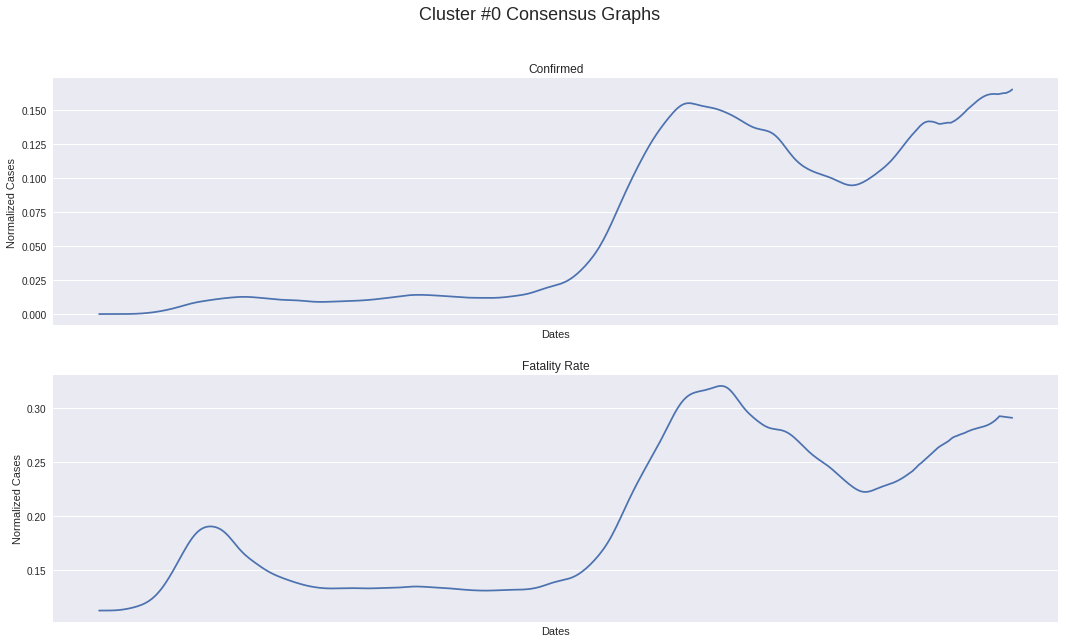

In [ ]:
full_cluster1 = get_consensus(df_normal, cluster_num=0)

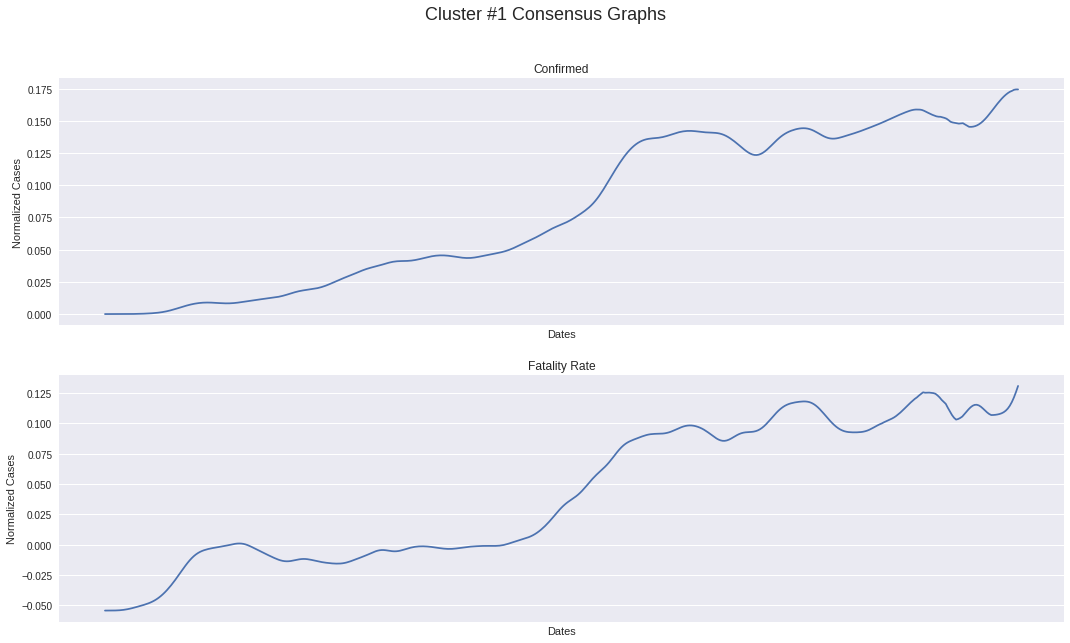

In [ ]:
full_cluster2 = get_consensus(df_normal, cluster_num=1)

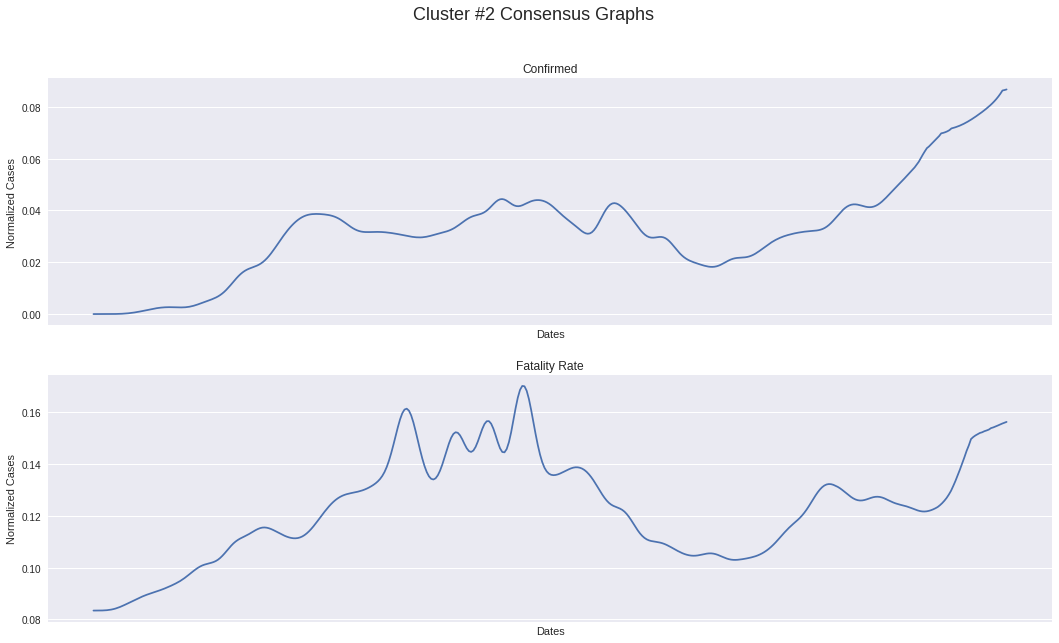

In [ ]:
full_cluster3 = get_consensus(df_normal, cluster_num=2)

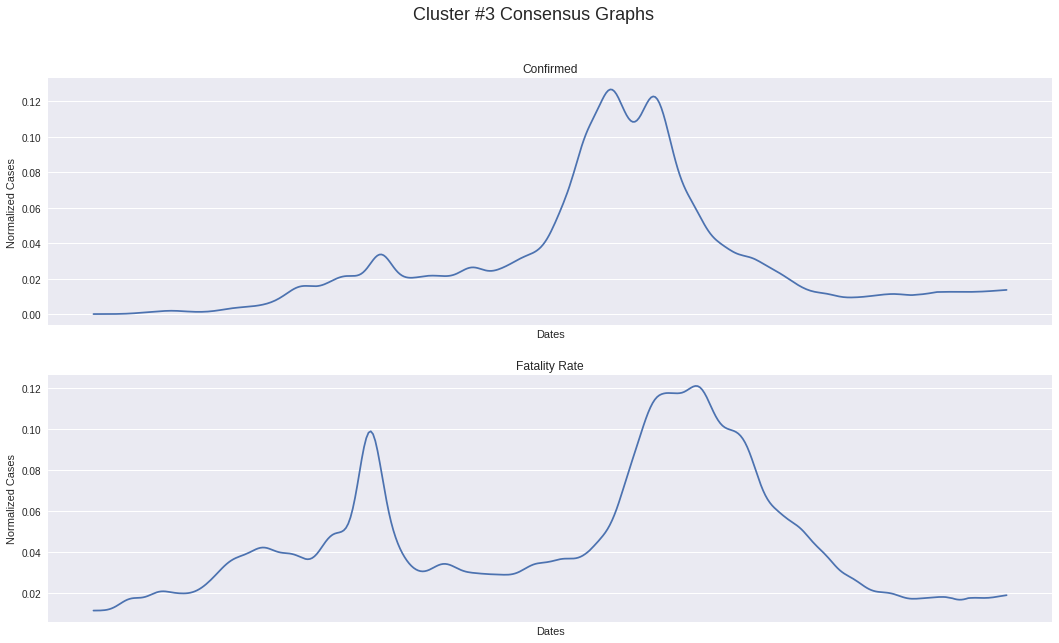

In [ ]:
full_cluster4 = get_consensus(df_normal, cluster_num=3)

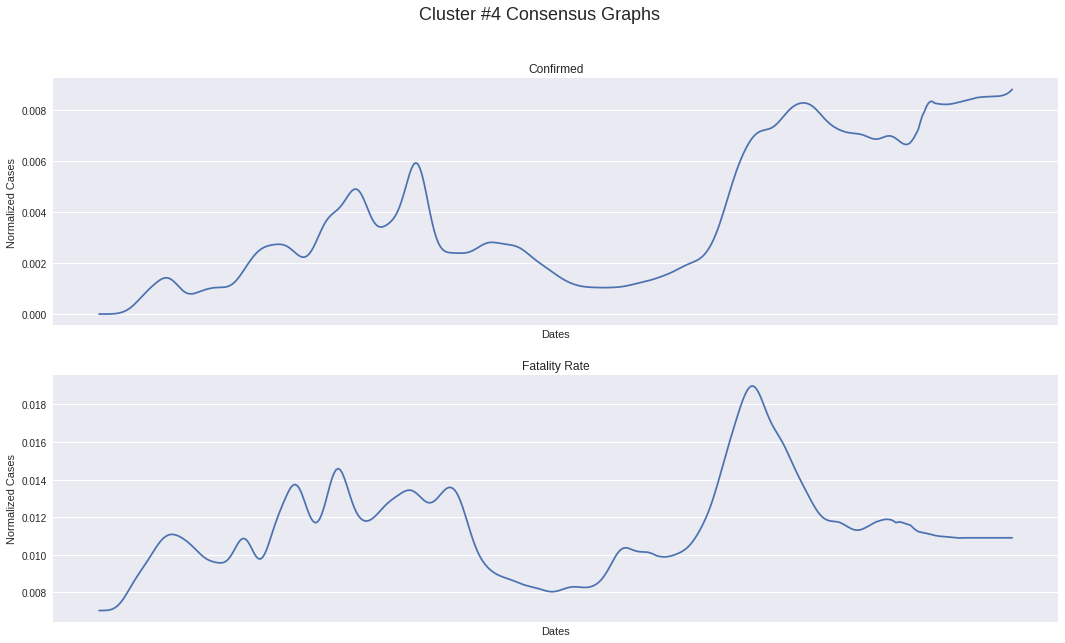

In [ ]:
full_cluster5 = get_consensus(df_normal, cluster_num=4)

### Save as CSV

In [ ]:
consensus_cluster1 = [value for key, value in full_cluster1.items() if 'confirmed' in key]
consensus_cluster2 = [value for key, value in full_cluster2.items() if 'confirmed' in key]
consensus_cluster3 = [value for key, value in full_cluster3.items() if 'confirmed' in key]
consensus_cluster4 = [value for key, value in full_cluster4.items() if 'confirmed' in key]
consensus_cluster5 = [value for key, value in full_cluster5.items() if 'confirmed' in key]

df_consensus = pd.DataFrame()
df_consensus['full_cluster_1'] = consensus_cluster1
df_consensus['full_cluster_2'] = consensus_cluster2
df_consensus['full_cluster_3'] = consensus_cluster3
df_consensus['full_cluster_4'] = consensus_cluster4
df_consensus['full_cluster_5'] = consensus_cluster5

df_consensus.head()

,full_cluster_1,full_cluster_2,full_cluster_3,full_cluster_4,full_cluster_5
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2.755113e-09,4.491881e-09,4.518808e-09,1.607871e-08,3.153759e-08
2,1.774020e-08,2.990550e-08,2.832332e-08,9.543497e-08,1.623090e-07
3,6.667026e-08,1.148619e-07,1.077377e-07,3.344830e-07,5.173740e-07
4,1.931441e-07,3.380770e-07,3.180122e-07,9.003371e-07,1.304120e-06


In [ ]:
df_consensus.to_csv(os.path.join(BASE_DIR, 'powerbi_full_consensus.csv'))

## 6-Month Dataset

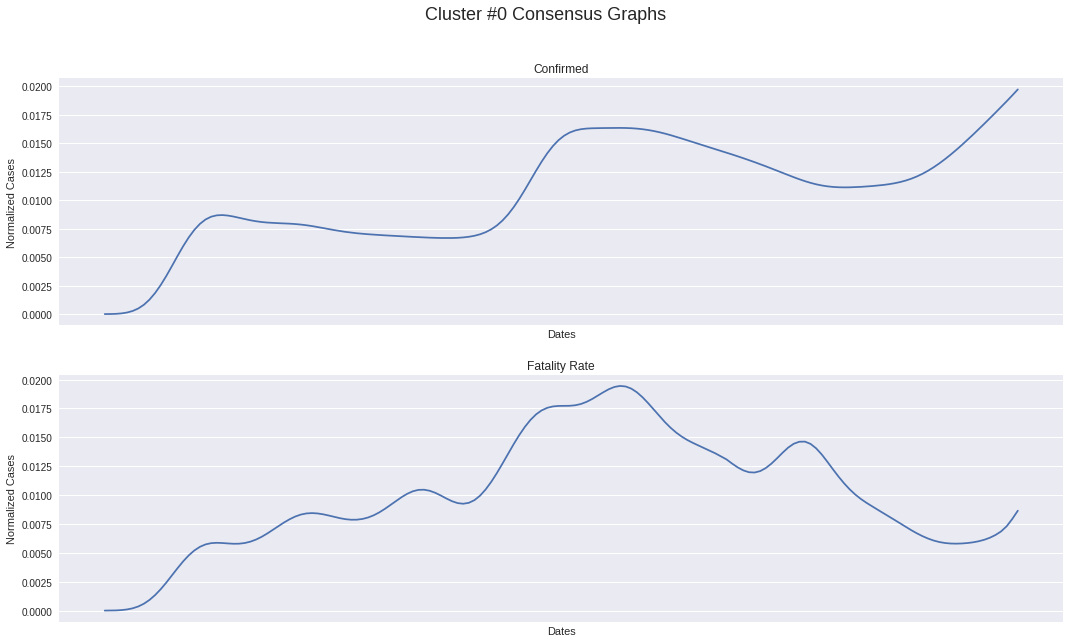

In [ ]:
partial_cluster1 = get_consensus(df_6months, cluster_num=0, last_columns=18)

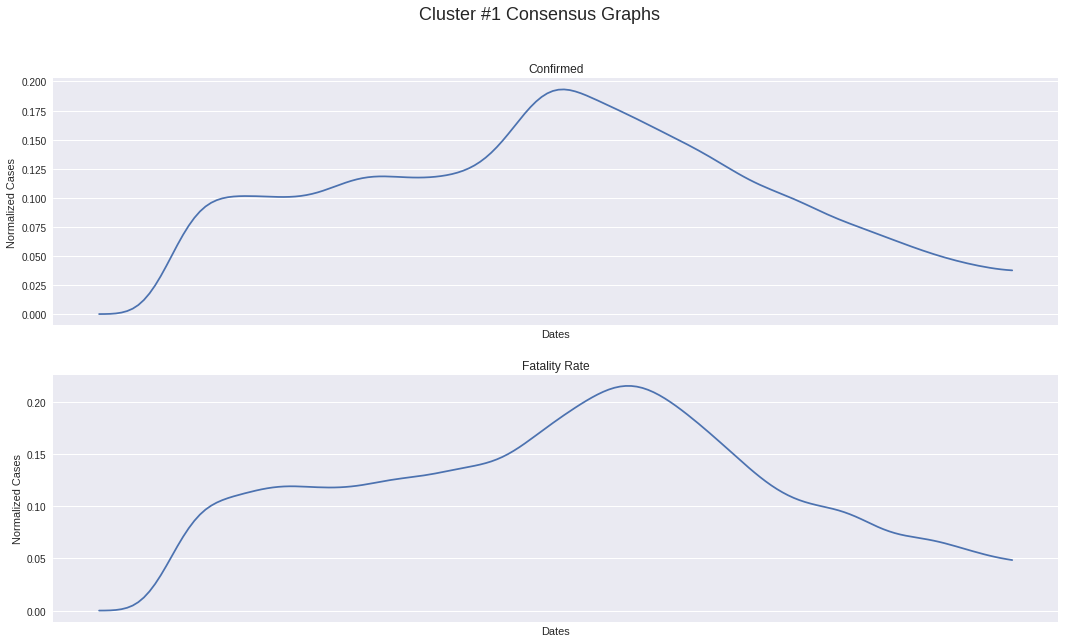

In [ ]:
partial_cluster2 = get_consensus(df_6months, cluster_num=1, last_columns=18)

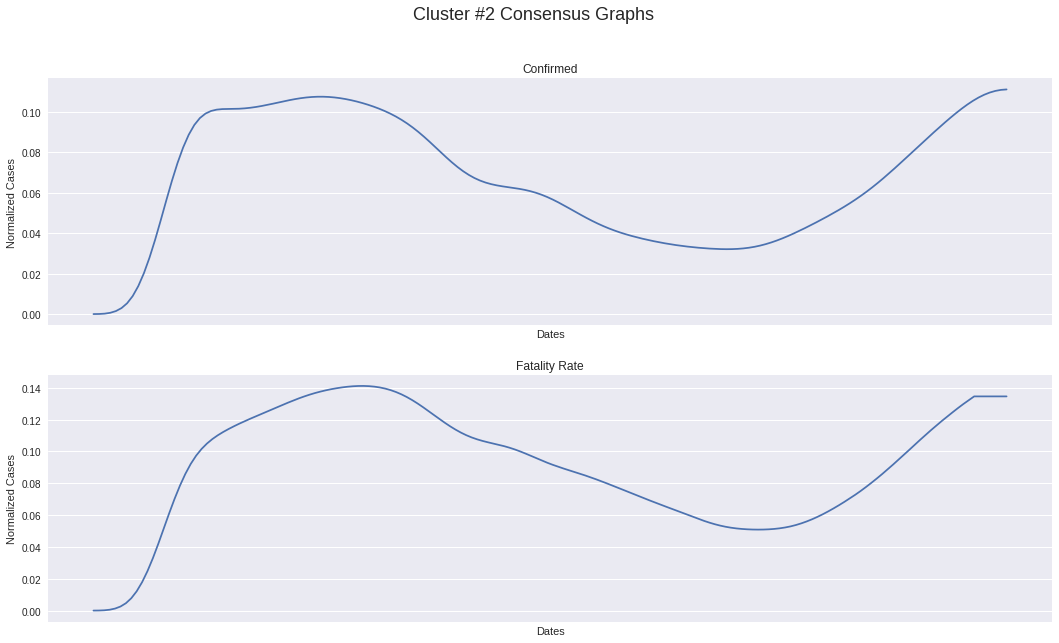

In [ ]:
partial_cluster3 = get_consensus(df_6months, cluster_num=2, last_columns=18)

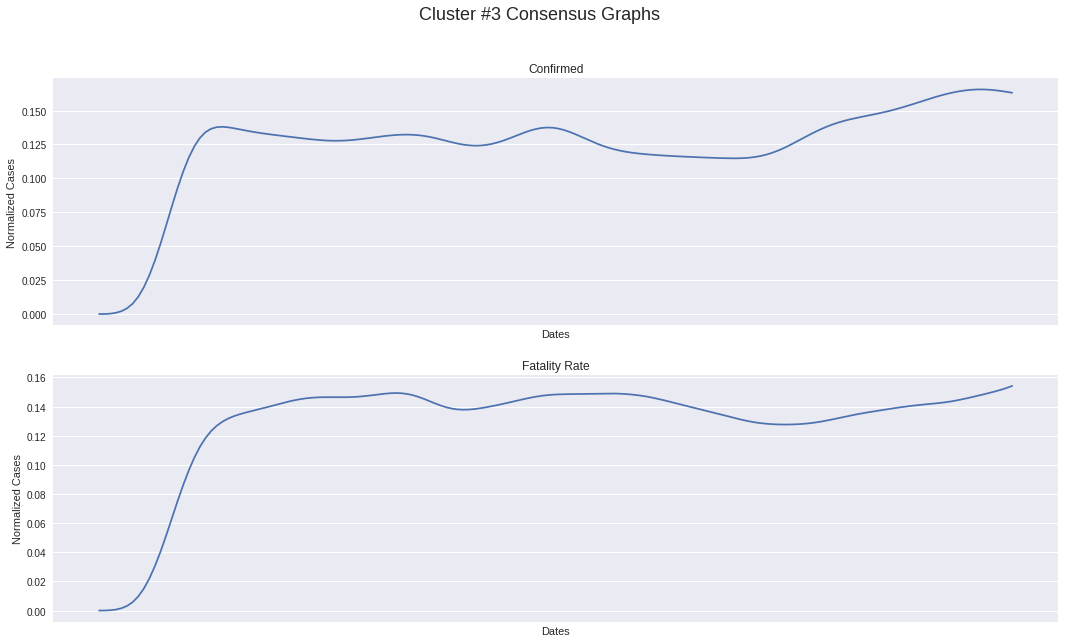

In [ ]:
partial_cluster4 = get_consensus(df_6months, cluster_num=3, last_columns=18)

### Save as CSV

In [ ]:
consensus_cluster1_6months = [value for key, value in partial_cluster1.items() if 'confirmed' in key]
consensus_cluster2_6months = [value for key, value in partial_cluster2.items() if 'confirmed' in key][:164]
consensus_cluster3_6months = [value for key, value in partial_cluster3.items() if 'confirmed' in key]
consensus_cluster4_6months = [value for key, value in partial_cluster4.items() if 'confirmed' in key]

df_consensus_6months = pd.DataFrame()
df_consensus_6months['6months_cluster_1'] = consensus_cluster1_6months
df_consensus_6months['6months_cluster_2'] = consensus_cluster2_6months
df_consensus_6months['6months_cluster_3'] = consensus_cluster3_6months
df_consensus_6months['6months_cluster_4'] = consensus_cluster4_6months

df_consensus_6months.head()

,6months_cluster_1,6months_cluster_2,6months_cluster_3,6months_cluster_4
0,0.000000,0.000000,0.000000,0.000000
1,0.000004,0.000036,0.000042,0.000061
2,0.000020,0.000181,0.000209,0.000304
3,0.000059,0.000545,0.000628,0.000914
4,0.000137,0.001277,0.001471,0.002134


In [ ]:
df_consensus_6months.to_csv(os.path.join(BASE_DIR, 'powerbi_6months_consensus.csv'))